In [1]:
#Importar librerias
import pandas as pd
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

In [2]:
#Importar los datos en un dataframe
data = pd.read_csv('./facebook-grupo.csv',sep= ";", encoding = 'latin-1', decimal =",")
data['Fecha']=pd.to_datetime(data['Fecha'],format="%d-%m-%Y %H:%M:%S")

#Limpiar los datos y ajustar el formato de la fecha
data = data.dropna(subset=['Fecha'])
data['mes']=data['Fecha'].apply(lambda x: f'{x.month}-{x.year}')

In [3]:
#Pasar mes a datetime y crear columna demanda
data['mes2']= data['mes'].apply(lambda x: datetime.strptime(x,"%m-%Y"))
data['demanda']=data['Comentarios']+data['Likes']


In [4]:
#Crear la pivot table de los datos
pdata = pd.pivot_table(data,values=['PageID','demanda'],index='mes2',aggfunc={'PageID':'count','demanda':'sum'})
pdata = pdata.rename(columns={'PageID':'oferta'})

#Eliminar valor atipico
pdata.drop(datetime(2020,7,1),inplace=True)

#modelar datos vacios
idx = pd.date_range(start=pdata.index.min(),end = pdata.index.max(),freq = 'MS')
pdata = pdata.reindex(idx)
pdata['demanda'].interpolate(method='cubic',inplace=True)
pdata['oferta'].interpolate(method='cubic',inplace=True)

#definir scaler y escalar demanda, oferta y equilibrio
scaler = preprocessing.StandardScaler()
pdata[['demanda','oferta']]= scaler.fit_transform(pdata[['demanda','oferta']])
pdata['equi'] = pdata['demanda']/pdata['oferta']
pdata[['equi']]= scaler.fit_transform(pdata[['equi']])

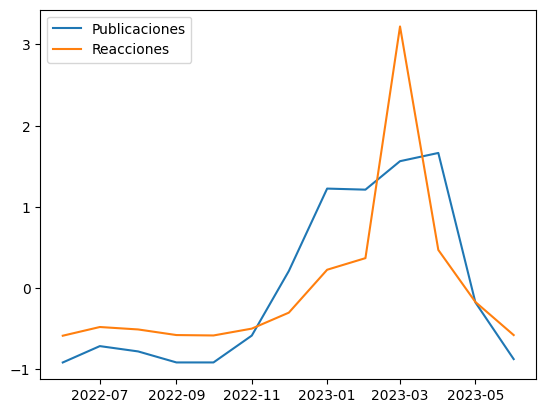

In [5]:
#Graficar datos

x=pdata.index
y1=pdata['oferta']
y2=pdata['demanda']


plt.plot(x , y1,  label='Publicaciones')
plt.plot(x , y2, label='Reacciones')

plt.legend()
plt.show()

In [6]:
#importación de datos del indice actividad comercial (IAC)
iac = pd.read_csv('/Users/AndresG/Desktop/Python-Shits/Proyectos-Pymetools/FacebookScrap/base-de-datos-a-abril-csv-2023.csv',sep= ";", encoding = 'latin-1', decimal =",")

#Procesamiento de datos, para igualar formato de fecha al df de facebook
iac = iac.dropna(subset='mes')
iac['mes']=iac['mes'].astype(str)+'-'+iac['año'].astype(str)
iac['mes']=iac['mes'].apply(lambda x: datetime.strptime(x,"%m-%Y"))
piac = pd.pivot_table(iac,values=['12'],index={'mes','Clase'},aggfunc={'12':'sum'})
piac =piac.reset_index()

#Función para marcar la clase de comercio al detalle dentrto de los datos
def claseok(num):
    if num!='47':
        return np.nan
    else:
        return num

#Filtrar clases de interes y crear pivot table del IAC
piac['Clase2']=piac['Clase'].astype(str).apply(lambda x: claseok(x[:2])) 
piac = piac.dropna(subset='Clase2')
piac = piac.drop(labels='Clase2',axis=1)
piac = pd.pivot_table(piac,index='mes',columns='Clase',values='12')
clases = piac.columns.values

#escalar valores de cada clase del IAC
piac[clases] = scaler.fit_transform(piac[clases])

In [7]:
#Combinar tablas de Facebook e IAC en una 
dfinal = pd.merge(pdata,piac,left_index=True,right_index=True)

In [8]:
#Separar valores explicativos del modelo
demanda = dfinal['demanda'].values
oferta = dfinal['oferta'].values
equilibrio = dfinal['equi'].values

X = np.array([demanda,oferta,equilibrio]).T

In [15]:
#Definir funcion de regresión 
reg = LinearRegression()

#crear dataframe para guardar coeficiente e indicadores de ajuste del modelo
resultados = pd.DataFrame(columns=['Clase','coef_dem','coef_ofe','coef_equi','r2'])
for clase in clases:
    ventas = dfinal[clase].values
    Y = np.array(ventas)
 
    reg = reg.fit(X,Y)
    Y_pred = reg.predict(X)
    error = np.sqrt(mean_squared_error(Y,Y_pred))
    r2 = reg.score(X,Y)
    coef_dem, coef_ofe, coef_equi = reg.coef_
    row = pd.DataFrame({'Clase': [clase],
           'coef_dem': [coef_dem],
           'coef_ofe': [coef_ofe],
           'coef_equi': [coef_equi],
           'r2': [r2]})
    resultados = pd.concat([resultados,row],ignore_index=True)

print(resultados.to_markdown())


|    |   Clase |   coef_dem |   coef_ofe |   coef_equi |       r2 |
|---:|--------:|-----------:|-----------:|------------:|---------:|
|  0 |    4711 |  0.657763  |  -0.373358 |  -0.596054  | 0.796059 |
|  1 |    4719 |  0.886781  |  -0.787146 |  -0.918197  | 0.845588 |
|  2 |    4720 |  0.655338  |  -0.428561 |  -0.514778  | 0.769021 |
|  3 |    4730 |  0.0871763 |  -0.44246  |  -0.0743451 | 0.676879 |
|  4 |    4740 |  1.01208   |  -0.685242 |  -0.843453  | 0.705913 |
|  5 |    4752 |  0.230221  |  -0.111666 |  -0.0594886 | 0.255004 |
|  6 |    4759 |  1.05358   |  -0.872468 |  -0.930228  | 0.89518  |
|  7 |    4760 |  1.16361   |  -0.667593 |  -0.901749  | 0.808806 |
|  8 |    4771 |  1.04938   |  -0.738711 |  -1.12016   | 0.905774 |
|  9 |    4772 |  0.814616  |  -0.434286 |  -0.558754  | 0.635126 |
| 10 |    4773 |  0.767292  |  -0.656908 |  -0.64517   | 0.800954 |


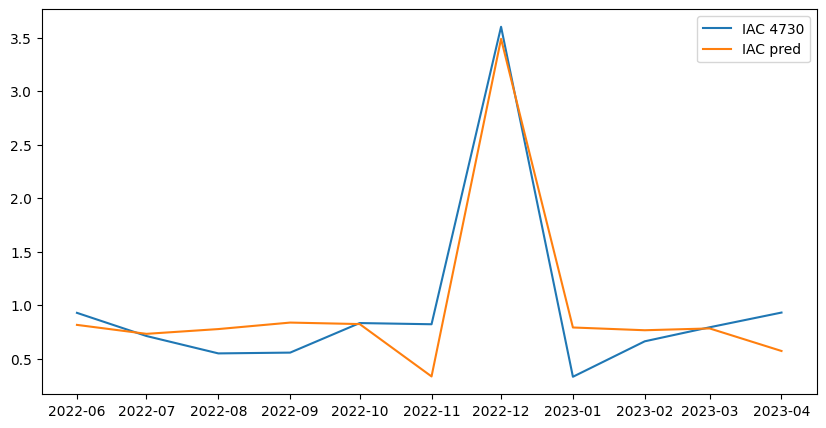

In [10]:
#Graficar modelo en el que mejor se adecuan los datos
xt = dfinal.index
y1 = dfinal[4771]
Y = np.array(y1.values)

reg = reg.fit(X,Y)
y_pred = reg.predict(X)


plt.figure(figsize=(10,5))

plt.plot(xt , y1,  label='IAC 4730')
plt.plot(xt , y_pred, label='IAC pred')

plt.legend()
plt.show()